In [192]:
from importlib import reload

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
from Signal_Analysis.features.signal import get_HNR
from sklearn import (
    cluster,
    tree,
    ensemble,
    preprocessing,
    decomposition,
    model_selection,
)
from tslearn.metrics import dtw

from vosk import Model

# tools work in progress
import tools

reload(tools)

plt.style.use("dark_background")
mpl.rcParams["lines.linewidth"] = 0.5
plt.close("all")

## data

i skymningen en mycket het dag i början av juli lämnade en ung man sin kammare som han hörde vid s grand steg ut på gatan och började långsamt och med samma obeslutsam går bort mot jobb men lyckligtvis slapp han möter värdinnan i kappan fanns kammare som låg alldeles in under den höga fem veckor aning byggnadens tak liknande snart ska jag köpa en bostad värdinnan som hyrde ut vind skutan och höll honom med middag som jag mål och städning bodde för sig i en våningen trappar trappa ner och när han skulle ut måste hem passera värdinnan kex ingång där döden nästan alltid sture


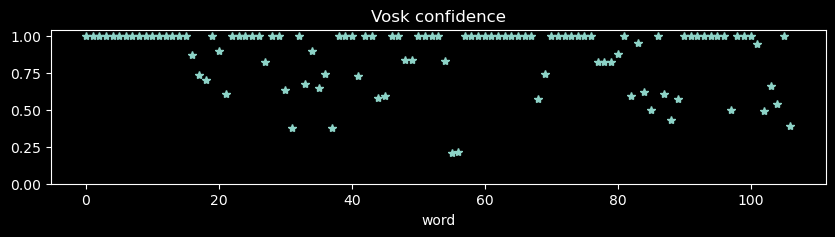

In [193]:
audio_path = "audio_preproc/180923214834-Y20UOTIE-text-000_pp.wav"
Fs, audio = wavfile.read(audio_path)

fl = int(0.02 * Fs)

audio_norm = audio / audio.std()
frames_all, f_start_all = tools.split_frames(audio_norm, fl, Fs, vol_thr=0.1)
f_start_all = f_start_all[:-1]
frames_all = np.array(frames_all[:-1])

model_path = "models/vosk-model-small-sv-rhasspy-0.15/"
if "model" not in locals():
    model = Model(model_path)

if "words" not in locals():
    words = tools.rec_vosk(audio_path, model, print_summary=True)

text = " ".join([w["word"] for w in words])


print(text)
plt.figure(figsize=(10, 2))
plt.plot([w["conf"] for w in words], "*")
plt.title("Vosk confidence")
plt.xlabel("word")
plt.ylim(bottom=0)
plt.show()

In [194]:
# get all vowels
for w in words:
    w["vowels"] = tools.checkVowels(w["word"], tools.VOWELS_SV)

for i, w in enumerate(words):
    print(i, w["word"], w["vowels"], str(w["conf"] * 100) + "%")

0 i ['i'] 100.0%
1 skymningen ['y', 'i', 'e'] 100.0%
2 en ['e'] 100.0%
3 mycket ['y', 'e'] 100.0%
4 het ['e'] 100.0%
5 dag ['a'] 100.0%
6 i ['i'] 100.0%
7 början ['ö', 'a'] 100.0%
8 av ['a'] 100.0%
9 juli ['u', 'i'] 100.0%
10 lämnade ['ä', 'a', 'e'] 100.0%
11 en ['e'] 100.0%
12 ung ['u'] 100.0%
13 man ['a'] 100.0%
14 sin ['i'] 100.0%
15 kammare ['a', 'a', 'e'] 100.0%
16 som ['o'] 87.0501%
17 han ['a'] 73.67869999999999%
18 hörde ['ö', 'e'] 70.1671%
19 vid ['i'] 100.0%
20 s [] 89.281%
21 grand ['a'] 60.827799999999996%
22 steg ['e'] 100.0%
23 ut ['u'] 100.0%
24 på ['å'] 100.0%
25 gatan ['a', 'a'] 100.0%
26 och ['o'] 100.0%
27 började ['ö', 'a', 'e'] 81.8951%
28 långsamt ['å', 'a'] 100.0%
29 och ['o'] 100.0%
30 med ['e'] 63.4952%
31 samma ['a', 'a'] 37.5446%
32 obeslutsam ['o', 'e', 'u', 'a'] 100.0%
33 går ['å'] 67.3912%
34 bort ['o'] 89.4242%
35 mot ['o'] 64.3671%
36 jobb ['o'] 73.9019%
37 men ['e'] 37.8958%
38 lyckligtvis ['y', 'i', 'i'] 100.0%
39 slapp ['a'] 100.0%
40 han ['a'] 100.0%

In [195]:
words_conf1 = [w for w in words if w["conf"] >= 1]

segments, vowels_per_segment = tools.segment_by_words(
    words, audio, Fs, tools.VOWELS_SV, signal_pad=0.02
)
segments_conf1 = []

for i, w in enumerate(words):
    if w["conf"] >= 1:
        segments_conf1.append(segments[i])

## Look at one word

mycket
['y', 'e']
mfcc (19, 5)


c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


[0. 0. 0. 1. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
0.21052631578947367


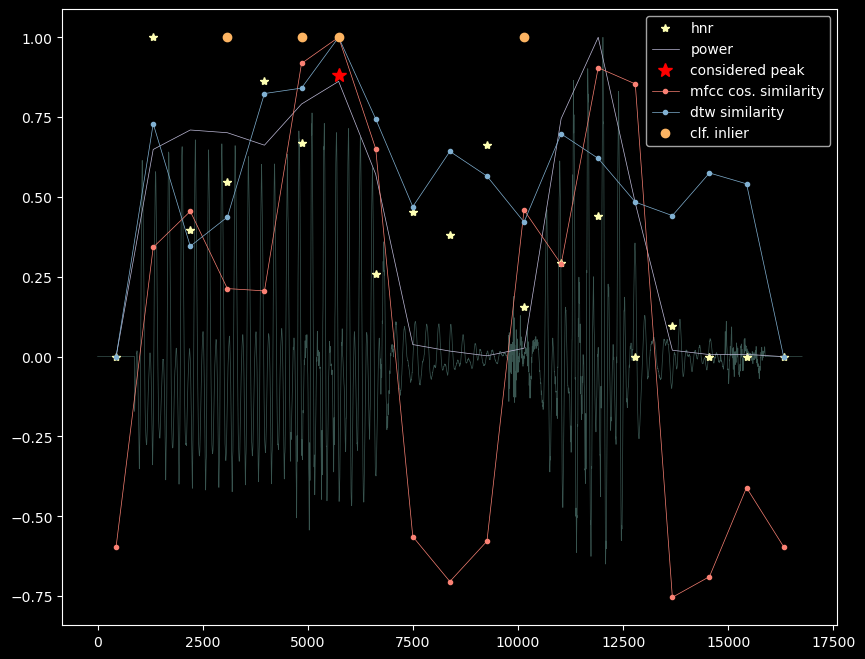

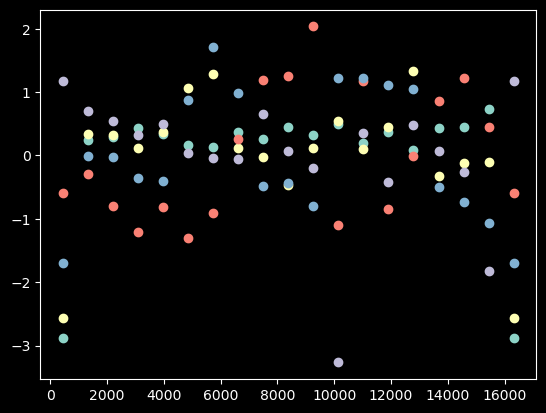

In [196]:
reload(tools)
k = 3
w = words_conf1[k]

print(w["word"])

x = segments_conf1[k] / segments_conf1[k].max()
x = np.concatenate((np.zeros(fl), x, np.zeros(fl)))
vowels = w["vowels"]
print(vowels)

frames, f_start = tools.split_frames(x, fl, Fs, overlap=0, print_info=False)

peak_frames, hnr_frames = tools.HNR_peaks(frames, Fs, len(vowels))

hnr_env = tools.envelope(hnr_frames, 1, 1)
power_frames = np.array([np.mean(f**2) for f in frames])

mfcc_frames = np.array(tools.get_mfcc(frames, Fs, n=5))
sc_mfcc = preprocessing.StandardScaler()
mfcc_frames = sc_mfcc.fit_transform(mfcc_frames)

print("mfcc", mfcc_frames.shape)
# look at one peak
p = peak_frames[1]
f = frames[p]

# Cosine similarity of mel features
mfcc_peak = mfcc_frames[p]
mfcc_sim = np.array(
    [
        np.dot(mfcc_peak, f) / (np.linalg.norm(mfcc_peak) * np.linalg.norm(f))
        for f in mfcc_frames
    ]
)
# DTW to peak frame
dtw_diff = np.array(
    [dtw(tools.normalize_std(frames[p]), tools.normalize_std(f)) for f in frames]
)

## Classify
w = 5  # unknown width
# Which frames are considered as known out-liers, last elemnt is inlier
clf_index = np.concatenate((range(0, p - w), range(p + w + 1, len(frames)), [p]))
x_train = mfcc_frames[clf_index]
y = np.zeros(len(clf_index))
y[-1] = 1  # Label inlier

clf = tree.DecisionTreeClassifier()
clf.fit(x_train, y)

inliers = clf.predict(mfcc_frames)

print(inliers)
print(sum(inliers / len(inliers)))


plt.figure(figsize=(10, 8))
plt.plot(np.arange(len(x)), x / x.max(), alpha=0.4)
plt.plot(f_start + fl / 2, hnr_frames / hnr_frames.max(), "*", label="hnr")
plt.plot(f_start + fl / 2, power_frames / power_frames.max(), "-", label="power")

plt.plot(
    f_start[p] + fl / 2,
    hnr_frames[p] / hnr_frames.max(),
    "*r",
    markersize=10,
    label="considered peak",
)
plt.plot(
    f_start + fl / 2, mfcc_sim / mfcc_sim.max(), ".-", label="mfcc cos. similarity"
)
plt.plot(
    f_start + fl / 2, 1 - (dtw_diff / dtw_diff.max()), ".-", label="dtw similarity"
)

plt.plot(
    f_start[inliers == 1] + fl / 2,
    np.ones_like(f_start[inliers == 1]),
    "o",
    label="clf. inlier",
)

plt.legend()
plt.show()

plt.figure()
plt.plot(f_start + fl / 2, mfcc_frames, "o")

## all words

In [197]:
reload(tools)

grouped_frames = {v: [] for v in tools.VOWELS_SV}
grouped_features = {v: [] for v in tools.VOWELS_SV}
grouped_hnr = {v: [] for v in tools.VOWELS_SV}

for k, w in enumerate(words_conf1):
    word = w["word"]

    x = segments_conf1[k] / segments_conf1[k].max()
    x = np.concatenate((np.zeros(fl), x, np.zeros(fl)))
    vowels = w["vowels"]

    # MAYBE SHOULDNT VOL THRESHOLD HERE, FALSE PEAKS
    frames, f_start = tools.split_frames(
        x, fl, Fs, overlap=0, vol_thr=0.0, print_info=False
    )

    peak_frames, hnr_frames = tools.HNR_peaks(frames, Fs, len(vowels))

    for i, p in enumerate(peak_frames):
        v = vowels[i]
        f = frames[p]
        grouped_frames[v].append(f)
        mfcc = tools.get_mfcc(f, Fs, n=20, normalize=True)
        feat_vec = np.concatenate((mfcc, [hnr_frames[p]]))
        grouped_features[v].append(feat_vec)
        grouped_hnr[v].append(hnr_frames[p])

c:\Users\marcu\anaconda3\envs\timeseries\Lib\site-packages\librosa\feature\spectral.py:2143: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  mel_basis = filters.mel(sr=sr, n_fft=n_fft, **kwargs)


In [198]:
print("# frames per vowel")
for v in grouped_frames.keys():
    print(v, len(grouped_frames[v]))

# features_df = pd.DataFrame.from_dict(grouped_features)

# display(features_df.head())

# frames per vowel
o 10
u 8
ö 4
a 33
å 3
ä 6
i 18
y 4
e 22


In [199]:
v = "e"
frames = grouped_frames[v]
X = np.array(grouped_features[v])
# X = np.array(np.array(grouped_hnr[v]).reshape(-1, 1))

sc_X = preprocessing.StandardScaler()
X = sc_X.fit_transform(X)
print(X.shape)

(22, 21)


## outliers?

inliers 68.0 %


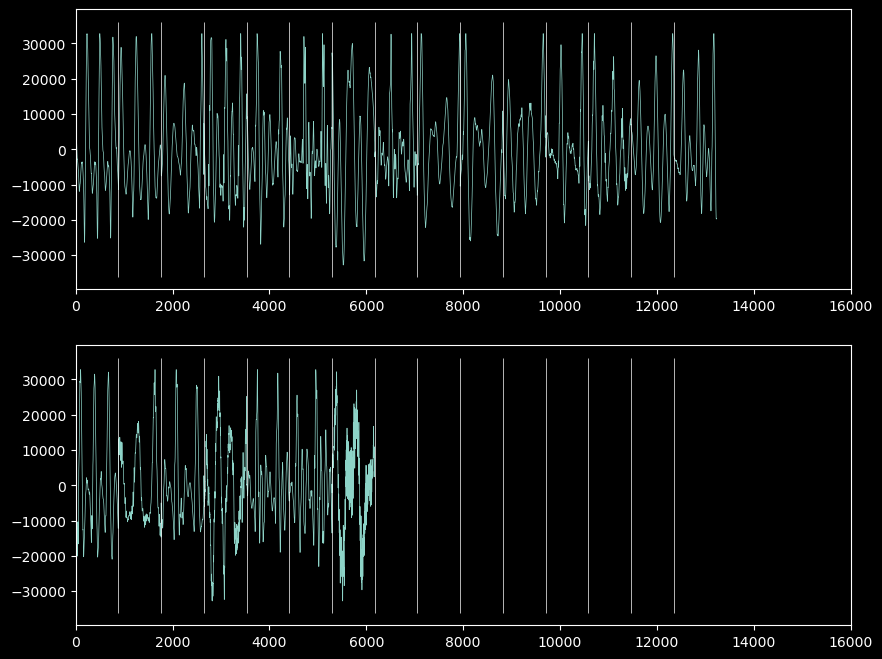

In [200]:
clf = ensemble.IsolationForest(random_state=0)
clf.fit(X)

inliers = clf.predict(X) > 0

print(f"inliers {np.around(100*sum(inliers)/len(X))} %")

frames_inlier = []
frames_outlier = []
for k in range(len(inliers)):
    if inliers[k]:
        frames_inlier.append(grouped_frames[v][k])
    else:
        frames_outlier.append(grouped_frames[v][k])

stitched_in = tools.stitch_frames(frames_inlier)
stitched_out = tools.stitch_frames(frames_outlier)

plt.figure(figsize=(10, 8))
plt.subplot(2, 1, 1)
plt.plot(stitched_in)
plt.xlim(0, 16000)
plt.vlines(np.arange(stop=len(stitched_in), step=fl), *plt.ylim())
plt.subplot(2, 1, 2)
plt.plot(stitched_out)
plt.xlim(0, 16000)
plt.vlines(np.arange(stop=len(stitched_in), step=fl), *plt.ylim())

wavfile.write("output/liers_in.wav", Fs, stitched_in)
wavfile.write("output/liers_out.wav", Fs, stitched_out)

## Visualize found frames

total points 108
X: (108, 21)
inliers 89.0 %
(108, 2)


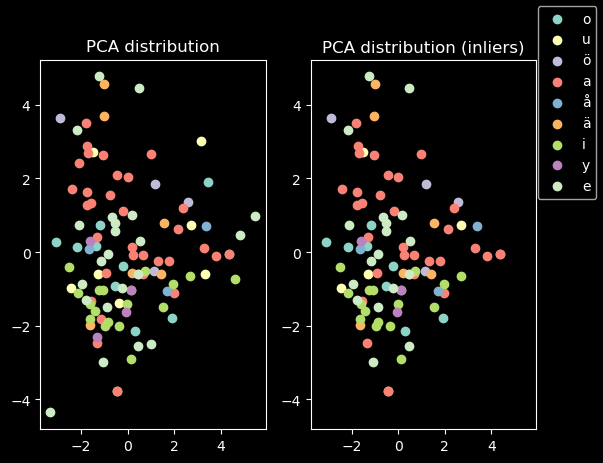

[3.62330853 3.37152322]


In [201]:
labels = []  # list of vowel labels
feature_vects = []
for v in grouped_features.keys():
    for f in grouped_features[v]:
        labels.append(v)
        feature_vects.append(f)
labels = np.array(labels)
print("total points", len(labels))

X = np.array(feature_vects)
sc_X = preprocessing.StandardScaler()
X = sc_X.fit_transform(X)
print("X:", X.shape)

# outliers
clf = ensemble.IsolationForest(random_state=0)
clf.fit(X)

inliers = clf.predict(X) > 0
X_in = X[inliers, :]
labels_in = labels[inliers]
print(f"inliers {np.around(100*sum(inliers)/len(X))} %")

# PCA decomp
pca = decomposition.PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca_in = pca.transform(X_in)

print(X_pca.shape)
plt.figure()
plt.subplot(121)
for v in grouped_features.keys():
    ind = labels == v
    plt.scatter(X_pca[ind, 0], X_pca[ind, 1])

xlim, ylim = plt.xlim(), plt.ylim()
plt.title("PCA distribution")

plt.subplot(122)
for v in grouped_features.keys():
    ind = labels_in == v
    plt.scatter(X_pca_in[ind, 0], X_pca_in[ind, 1], label=v)
plt.xlim(*xlim)
plt.ylim(*ylim)
plt.title("PCA distribution (inliers)")
plt.figlegend()

plt.show()

print(pca.explained_variance_)

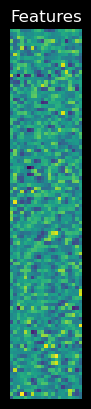

In [202]:
plt.figure()
plt.imshow(X)
plt.axis("off")
plt.title("Features")
plt.show()

### Test classifier accuracy

In [203]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    X_in, labels_in, test_size=0.3
)
clf = tree.DecisionTreeClassifier()
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
print(clf.score(X_test, y_test))

print(clf.feature_importances_)

for i in range(len(y_test)):
    print(y_test[i], y_pred[i])

0.1724137931034483
[0.13977455 0.         0.         0.01874126 0.17720586 0.04685315
 0.05224212 0.         0.11064786 0.         0.04113793 0.04685315
 0.08391919 0.         0.07121678 0.03212787 0.         0.07948614
 0.04768609 0.03336679 0.01874126]
u ö
y a
a e
o u
å ä
a ö
e e
e a
i i
a a
a e
a u
e a
e i
a e
a a
i a
o e
i e
a ö
o u
o u
o a
å u
a a
a u
e o
e a
e i
